In [39]:
# imports and settings
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import MDAnalysis as mda
import seaborn as sns
import nglview as nv                            # for visualisation
from MDAnalysis.analysis.align import alignto   # for aligning structures
from MDAnalysis.analysis.pca import PCA         # for PCA
from Bio.PDB import PDBParser
from Bio.PDB.DSSP import DSSP                   # for secondary structure selection
from Bio.PDB.SASA import ShrakeRupley           # for SASA calculation
from IPython.display import display             # for data frame display
from multiprocessing import Pool                # for multiprocessing
from tqdm import tqdm                           # for progress bars

# surpress warnings
warnings.filterwarnings(action='ignore', module=r'.*randpool')

# pandas settings
pd.set_option('display.max_colwidth', None)

############################################################################################################

# base directories
base_directory = "/biggin/b212/bioc1781/Projects/CTNS/human/monomer/red-msa/content/"
structure_directory = base_directory + "Structures/" # directory with the AF2 ensemble, cannot be the same as base directory

# reference structures
outward_open_pdb = base_directory + "8DKE_cytosol_noNTD.pdb"
inward_open_pdb  = base_directory + "8DKI_lumen_noNTD.pdb"

# settings
selection_for_writeout = "protein and not (resid 358-367) and not (resid 260 and (not backbone))" # useful if you want all the outputs to have a specific selection
resid_offset    = 115           # first resID in the reference structures if the chain does not start from 1
# structure filtering
thresh_rmsd     = 6             # threshold for discarding structures based on RMSD
thresh_pLDDT    = 80            # threshold for discarding structures based on pLDDT
diffmat_thresh  = 0             # threshold for ignoring atoms in RMSD calculations based on how much they differ between the reference structures
# analysis
num_processes   = 12            # CPU cores to use for multiprocessing
n_pcs           = 3             # number of principal components to keep in PCA
# monte carlo
mc_temp         = 500           # monte carlo temperature
mc_wf_sasa      = 1             # monte carlo energy function weight factor for SASA
mc_n_runs       = 100000        # number of monte carlo runs
mc_n_bins       = 6             # so mc_n_bins is the total number of bins (because of reference structures and zero indexing)
collective_variable = 'PC1'     # collective_variable to bin for path finding
# for plotting
plot_variable_1     = 'PC1'   
plot_variable_2     = 'PC3'
plot_variable_3     = 'sasa'

############################################################################################################

# universes for reference structures
u_outward_open = mda.Universe(outward_open_pdb, outward_open_pdb)
u_inward_open  = mda.Universe(inward_open_pdb, inward_open_pdb)

# align reference structures to eachother
alignto(u_inward_open, u_outward_open, select='name CA', weights="mass")

# write reindexed pdbs of reference structures for inclusion in the ensemble
u_outward_open.atoms.residues.resids -= resid_offset
u_outward_open.atoms.write(structure_directory + "ref_outward.pdb")
u_outward_open.atoms.residues.resids += resid_offset
#
u_inward_open.atoms.residues.resids -= resid_offset
u_inward_open.atoms.write(structure_directory + "ref_inward.pdb")
u_inward_open.atoms.residues.resids += resid_offset

# get list of all files in structure directory directory with the pdb extension
structures = [f for f in os.listdir(structure_directory) if f.endswith('.pdb')]
structures.sort()

/biggin/b212/bioc1781/anaconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:432: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"
/biggin/b212/bioc1781/anaconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:753: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "


In [ ]:
# automatic "clever" selection definer

# conserved residues
conserved_residues = []

# temporary universe
u = u_outward_open

# identify regions of secondary structure
p = PDBParser()
structure = p.get_structure('reference', outward_open_pdb)
model = structure[0]
dssp = DSSP(model, outward_open_pdb, dssp='mkdssp')

helices = []
sheets  = []
loops   = []

# get secondary structure labels for resIDs
for key in dssp.keys():
    if dssp[key][2] == 'H' or dssp[key][2] == 'G' or dssp[key][2] == 'I':
        helices.append(key[1][1])
    elif dssp[key][2] == 'E':
        sheets.append(key[1][1])
    elif dssp[key][2] == 'T' or dssp[key][2] == 'S':
        loops.append(key[1][1])
    
helices = sorted(list(set(helices)))
sheets = sorted(list(set(sheets)))
loops = sorted(list(set(loops)))

helices_contiguous = []
sheets_contiguous  = []
loops_contiguous   = []

# get contiguous regions of secondary structure
for i in range(len(helices)):
    if i == 0:
        helices_contiguous.append([helices[i]])
    elif helices[i] == helices[i-1] + 1:
        helices_contiguous[-1].append(helices[i])
    else:
        helices_contiguous.append([helices[i]])

for i in range(len(sheets)):
    if i == 0:
        sheets_contiguous.append([sheets[i]])
    elif sheets[i] == sheets[i-1] + 1:
        sheets_contiguous[-1].append(sheets[i])
    else:
        sheets_contiguous.append([sheets[i]])

for i in range(len(loops)):
    if i == 0:
        loops_contiguous.append([loops[i]])
    elif loops[i] == loops[i-1] + 1:
        loops_contiguous[-1].append(loops[i])
    else:
        loops_contiguous.append([loops[i]])

selection_helices = []
selection_sheets  = []
selection_loops   = []

# make mdanalysis selections corresponding to these regions
for i in range(len(helices_contiguous)):
    selection_helices.append('(resid %s-%s and (name CA))' % (helices_contiguous[i][0], helices_contiguous[i][-1]))
for i in range(len(sheets_contiguous)):
    selection_sheets.append('(resid %s-%s and (name CA))' % (sheets_contiguous[i][0], sheets_contiguous[i][-1]))
for i in range(len(loops_contiguous)):
    selection_loops.append('(resid %s-%s and (name CA))' % (loops_contiguous[i][0], loops_contiguous[i][-1]))

# format selections
selection_helices = ','.join(selection_helices)
selection_helices = selection_helices.replace(',', ' or ')
selection_sheets = ','.join(selection_sheets)
selection_sheets = selection_sheets.replace(',', ' or ')
selection_loops = ','.join(selection_loops)
selection_loops = selection_loops.replace(',', ' or ')

endstates = {}

# trying to be clever and getting rmsd_selection for which to compare rmsd by comparing the distance matrices of the two end states
for end_state in [u_outward_open, u_inward_open]:
    u = end_state.select_atoms('name CA')
    distance_matrix = []
    for i in u.atoms:
        for j in u.atoms:
                distance_matrix.append(np.linalg.norm(i.position - j.position)) # append distance between atoms to distance array
    
    # reshape to a square matrix and append to dictionary
    distance_matrix = np.array(distance_matrix).reshape((len(u.atoms),len(u.atoms)))
    endstates[end_state] = distance_matrix

# subtract the distance matrices to get the difference matrix
ca_dist_difference_matrix = endstates[u_outward_open] - endstates[u_inward_open]

resids_from_ca_dist_diffmat = []

# get the resid of the residues that differ by more than the threshold in absolute terms
above_thresh = np.where(abs(ca_dist_difference_matrix) >= diffmat_thresh)
for i in range(len(above_thresh[0])):
    resids_from_ca_dist_diffmat.append(u.atoms[above_thresh[0][i]].resid)
resids_from_ca_dist_diffmat = list(set(resids_from_ca_dist_diffmat))    # get unique residues

# make a selection token for these residues
selection_from_ca_dist_diffmat = []
for i in range(len(resids_from_ca_dist_diffmat)):
    selection_from_ca_dist_diffmat.append('resid %s' % resids_from_ca_dist_diffmat[i])
selection_from_ca_dist_diffmat = ','.join(selection_from_ca_dist_diffmat)
selection_from_ca_dist_diffmat = selection_from_ca_dist_diffmat.replace(',', ' or ')

# final rmsd_selection for analysis
rmsd_selection = '(((' + selection_helices + ') or (' + selection_loops + ')) and (' + selection_from_ca_dist_diffmat + '))' #+ ' and not (resid 116-120 or resid 356-367)'

# show the clipped difference matrix
#ca_dist_difference_matrix[np.where(abs(ca_dist_difference_matrix) < diffmat_thresh)] = 0
#plt.imshow(ca_dist_difference_matrix)
#plt.colorbar()

# show the selection using nglview
rmsd_selection_atoms = u_outward_open.select_atoms(rmsd_selection)
view = nv.show_mdanalysis(rmsd_selection_atoms)
view.add_licorice(selection=rmsd_selection, color='red')
view.center()
view



In [ ]:
# calculate RMSDs of all the structures relative to the reference structures

# get average positions and make new universe with these positions
average_positions = (u_outward_open.atoms.positions + u_inward_open.atoms.positions) / 2
u_average = mda.Universe(outward_open_pdb, outward_open_pdb)
u_average.atoms.positions = average_positions

# define function to get rmsd to a structure
def get_rmsd_to_structure(structure):
    mobile = mda.Universe(structure_directory + structure, structure_directory + structure) # make universe
    mobile.atoms.residues.resids += resid_offset                                            # renumber residues in mobile
    rmsds = alignto(mobile, ref, select=rmsd_selection, match_atoms=True, weights=None)     # these ref selections are different becasue ref has different residue numbering
    return [structure, rmsds[1]]                                                            # [1] = rmsd after alignment

# define a function to calculate the SASA of a structure
def get_sasa(structure):
    p = PDBParser(QUIET=1)
    struct = p.get_structure(structure, structure_directory + structure)
    sr = ShrakeRupley(probe_radius=1.4, n_points=100)
    sr.compute(struct, level="S")
    return [structure, struct.sasa]  

rmsd_to_outward = {}

# outward open
ref = u_outward_open
with Pool(processes=num_processes) as pool:
    rmsds = list(tqdm(pool.imap(get_rmsd_to_structure, structures), total=len(structures)))
rmsd_to_outward = dict(rmsds)   # make this list of tuples into a dictionary

rmsd_to_inward = {}

# inward open
ref = u_inward_open
with Pool(processes=num_processes) as pool:
    rmsds = list(tqdm(pool.imap(get_rmsd_to_structure, structures), total=len(structures)))
rmsd_to_inward = dict(rmsds)   # make this list of tuples into a dictionary

rmsd_to_average = {}

# average
ref = u_average
with Pool(processes=num_processes) as pool:
    rmsds = list(tqdm(pool.imap(get_rmsd_to_structure, structures), total=len(structures)))
rmsd_to_average = dict(rmsds)   # make this list of tuples into a dictionary

sasa_dict = {}

# solvent accesible surface areas
with Pool(processes=num_processes) as pool:
    sasas = list(tqdm(pool.imap(get_sasa, structures), total=len(structures)))
sasa_dict = dict(sasas)         # make this list of tuples into a dictionary


In [ ]:
# make big pandas dataframe and filter data
ensemble_df = pd.DataFrame.from_dict(rmsd_to_outward, orient='index', columns=['rmsd_to_outward'])
ensemble_df['rmsd_to_inward'] = rmsd_to_inward.values()
ensemble_df['rmsd_to_average'] = rmsd_to_average.values()

# take square root of sasa so values are in ansgroms (rather than square angstroms)
ensemble_df['sasa'] = sasa_dict.values()
ensemble_df['sasa'] = ensemble_df['sasa'].apply(np.sqrt)
ensemble_df['sasa_negative'] = ensemble_df['sasa'] * -1

# additional quantities
ensemble_df['rmsd_sum']    = ensemble_df['rmsd_to_outward'] + ensemble_df['rmsd_to_inward']
ensemble_df['rmsd_mean']   = ensemble_df['rmsd_sum'] / 2
ensemble_df['rmsd_ratio_outwardness'] = 1 - (ensemble_df['rmsd_to_outward'] / ensemble_df['rmsd_sum'])
ensemble_df['rmsd_ratio_inwardness']  = 1 - (ensemble_df['rmsd_to_inward'] / ensemble_df['rmsd_sum'])

pLDDT_scores = {}

# get pLDDT scores from text file in structures directory called file_details.txt that collabfold outputs
with open(structure_directory + 'file_details.txt') as f:
    for line in f:                                                                      # lookup pLDDT score for structure in ensemble_df in the file
        if line.split()[0] in ensemble_df.index:                                            # match the line that contains the structure name
            pLDDT_scores[line.split()[0]] = float(line.split()[1].replace('pLDDT:','')) # sanitize line.split()[1] by removing text

# add entries to dictionary for the reference structures with pLDDT scores of 100
pLDDT_scores['ref_outward.pdb'] = 100
pLDDT_scores['ref_inward.pdb'] = 100
ensemble_df['pDDLDT'] = pLDDT_scores.values()

# backup
df_backup = ensemble_df
# reset
ensemble_df = df_backup

# trim all entries with rmsd_mean > thesh # discard junk
ensemble_df = ensemble_df[ensemble_df['rmsd_mean'] < thresh_rmsd]    # discard > thresh_rmsd
ensemble_df = ensemble_df[ensemble_df['pDDLDT'] > thresh_pLDDT]      # discard < thresh_pLDDT

# get the sasa value for the inward and outward facing reference structures from the dataframe 
thresh_sasa = max(ensemble_df.loc['ref_outward.pdb']['sasa'], ensemble_df.loc['ref_inward.pdb']['sasa'])*1.01   # occluded state should not be more exposed than the reference structures
ensemble_df = ensemble_df[ensemble_df['sasa'] <= thresh_sasa]                                               # discard < thresh_sasa


/biggin/b212/bioc1781/anaconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:753: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/biggin/b212/bioc1781/anaconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"
/biggin/b212/bioc1781/anaconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:432: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"
/biggin/b212/bioc1781/anaconda3/lib/python3.9/site-packages/MDAnalysis/core/universe.py:641: UserWarning: Reader has no dt information, set to 1.0 ps
  dt=self.trajectory.ts.dt * step,


,PC1,PC2,PC3,PC4,structure
0,-7.227135,0.202485,-2.430710,-0.488563,pred_100.pdb
1,-6.003363,-1.124562,0.896149,-1.756011,pred_102.pdb
2,-4.330947,-1.816791,2.089424,-0.554662,pred_103.pdb
3,-6.547034,1.065021,2.452572,0.179001,pred_105.pdb
4,-9.228653,1.898989,2.054421,0.387672,pred_110.pdb


/biggin/b212/bioc1781/anaconda3/lib/python3.9/site-packages/MDAnalysis/analysis/pca.py:337: DeprecationWarning: The `cumulated_variance` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.cumulated_variance` instead.
  warnings.warn(wmsg, DeprecationWarning)


,PC cumulated variance
0,45.0
1,59.0
2,68.0
3,73.0
4,77.0


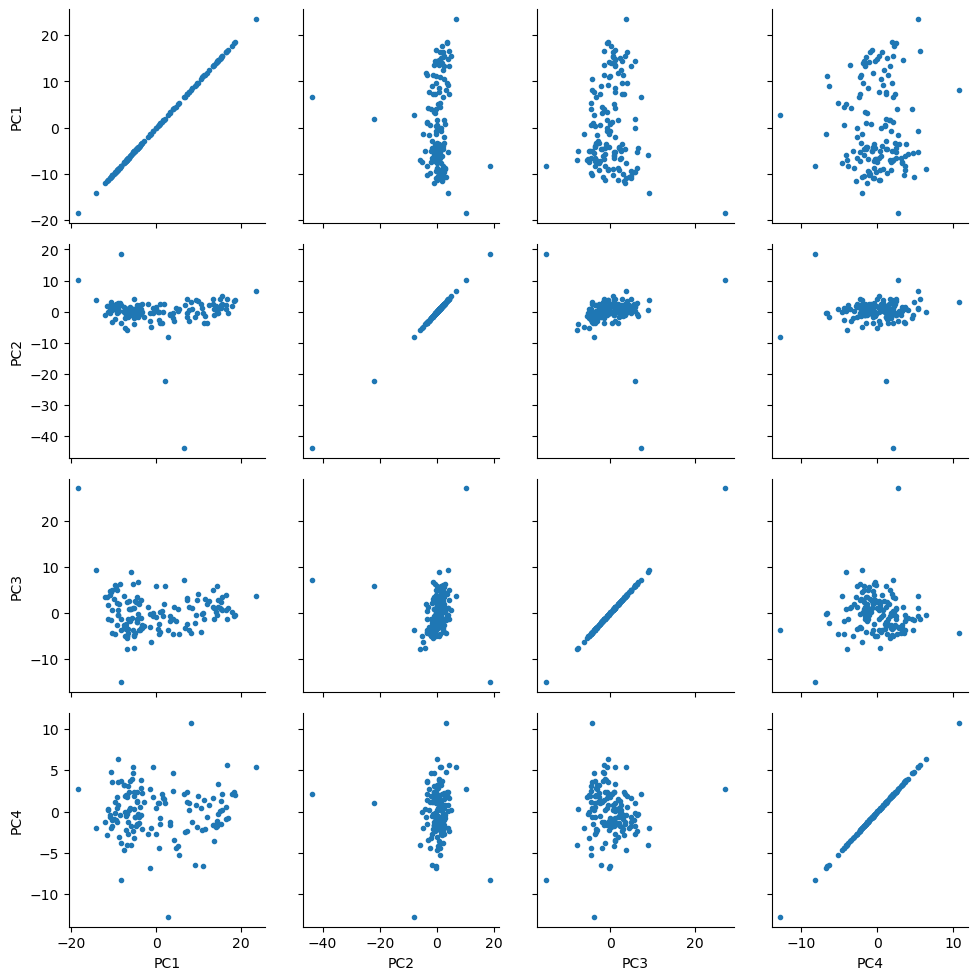

/biggin/b212/bioc1781/anaconda3/lib/python3.9/site-packages/MDAnalysis/analysis/pca.py:321: DeprecationWarning: The `p_components` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.p_components` instead.
  warnings.warn(wmsg, DeprecationWarning)
/biggin/b212/bioc1781/anaconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:753: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
/biggin/b212/bioc1781/anaconda3/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1129: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


In [40]:
# principal component analysis on filtered ensemble

# write a multistate pdb file for the whole ensemble so MDA will interpret it as a trajectory
with mda.Writer(base_directory + 'ensemble.pdb', u.atoms.n_atoms) as W:
    for structure in ensemble_df.index:
        u = mda.Universe(structure_directory + structure, 
                         structure_directory + structure)
        # renumber for consistency and to match selection token   s     
        u.atoms.residues.resids += resid_offset
        u.atoms.segments.segids = 'A'
        u.atoms.chainIDs = 'A'
        W.write(u.select_atoms(selection_for_writeout))
 
# make a universe containing all the structures
u = mda.Universe(base_directory + "ensemble.pdb")

# align the ensemble to the selection token
aligner = mda.analysis.align.AlignTraj(u, u, select=rmsd_selection, in_memory=True).run()

# perform principal component analysis
pc = PCA(u, select=rmsd_selection, align=True, mean=None, n_components=None).run()

# project coorindates onto the principal components
pc_projection = pc.transform(u.select_atoms(rmsd_selection), n_components=n_pcs)

# make a dataframe to store the principal components
pca_df = pd.DataFrame(pc_projection, columns=['PC{}'.format(i+1) for i in range(n_pcs)])
pca_df['structure'] = ensemble_df.index

# print out the PCs
display(pd.DataFrame(pca_df).head())

# show table of variances explained by each PC
display(pd.DataFrame((pc.cumulated_variance*100).round(), columns=['PC cumulated variance']).head())

g = sns.PairGrid(pca_df)
g.map(plt.scatter, marker='.')
plt.show()

# add principal components to the dataframe - making sure the structures are in the same order
pca_df = pca_df.sort_values(by=['structure'])
pca_df = pca_df.reset_index(drop=True)
ensemble_df['PC1'] = pca_df['PC1'].values
ensemble_df['PC2'] = pca_df['PC2'].values
ensemble_df['PC3'] = pca_df['PC3'].values

# visualisation
n_pcs = 3
for i in range(n_pcs):
    pc_n =    pc.p_components[:, i]
    trans_n =   pc_projection[:, i]
    projected = np.outer(trans_n, pc_n) + pc.mean.flatten()
    coordinates = projected.reshape(len(trans_n), -1, 3)
    
    proj_n = mda.Merge(u.select_atoms(rmsd_selection))
    proj_n.load_new(coordinates)
    
    # write this to a multistate pdb file
    with mda.Writer(base_directory + 'pca{}.pdb'.format(i+1), proj_n.atoms.n_atoms) as W:
        for ts in proj_n.trajectory:
            W.write(proj_n.atoms)

In [ ]:
# trim junk structures and make plots

# tabulated results
print('Closest to end states:')
display(ensemble_df.sort_values(by=['rmsd_to_outward']).head(2)[['rmsd_to_outward', 'pDDLDT', 'sasa']])
display(ensemble_df.sort_values(by=['rmsd_to_inward']).head(2)[['rmsd_to_inward', 'pDDLDT', 'sasa']])
print('Closest to average:')
display(ensemble_df.sort_values(by=['rmsd_to_average']).head(1)[['rmsd_to_average', 'pDDLDT', 'sasa']])
print('Lowest 5 SASA:')
display(ensemble_df.sort_values(by=['sasa']).head(5)[['rmsd_to_outward', 'rmsd_to_inward', 'pDDLDT', 'sasa']])
print('Most different:')
display(ensemble_df.sort_values(by=['rmsd_mean']).tail(1)[['rmsd_to_outward', 'rmsd_to_inward', 'pDDLDT', 'sasa']])

# write pdb of closest to average
mobile = mda.Universe(structure_directory + ensemble_df.sort_values(by=['rmsd_to_average']).head(1).index[0], structure_directory + ensemble_df.sort_values(by=['rmsd_to_average']).head(1).index[0], rmsd_selection=rmsd_selection)
mobile.atoms.residues.resids += resid_offset
alignto(mobile, u_outward_open, select=rmsd_selection, match_atoms=True)
writeout=mobile.select_atoms(selection_for_writeout)
writeout.atoms.write(base_directory + 'closest_to_average.pdb')

# plot 2D x = ratio_outwardness, y = sasaa, coloured by ratio_inwardness
plt.scatter(ensemble_df[plot_variable_1], ensemble_df[plot_variable_2], c=ensemble_df[plot_variable_3], cmap='coolwarm')
plt.xlabel(plot_variable_1)
plt.ylabel(plot_variable_2)
plt.colorbar(label=plot_variable_3)
plt.annotate('outward facing', (ensemble_df.loc['ref_outward.pdb'][plot_variable_1], ensemble_df.loc['ref_outward.pdb'][plot_variable_2]))
plt.annotate('inward facing', (ensemble_df.loc['ref_inward.pdb'][plot_variable_1], ensemble_df.loc['ref_inward.pdb'][plot_variable_2]))
plt.show()

# plot histogram of rmsd_to_outward and rmsd_to_inward
plt.hist(ensemble_df['rmsd_to_outward'], bins=20, alpha=0.5, label='outward facing')
plt.hist(ensemble_df['rmsd_to_inward'], bins=20, alpha=0.5, label='inward facing')
plt.legend(loc='upper right')
plt.xlabel('RMSD')
plt.ylabel('Count')
plt.xlim(0)
fig = plt.gcf()
fig.set_size_inches(10, 2)
plt.show()

# plot 2 pane histogram of SASA and pLDDT scores
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(ensemble_df['sasa'], bins=20, alpha=0.5, label='sasa', color='C3')
ax1.set_xlabel('SASA')
ax1.set_ylabel('Count')
ax2.hist(ensemble_df['pDDLDT'], bins=20, alpha=0.5, label='pDDLDT')
ax2.set_xlabel('pDDLDT')
fig.set_size_inches(10, 2)
plt.show()


In [ ]:
# parallel calculation of the pairwise RMSD matrix (for the MC energy function used in the next cell)

# Initialize a matrix to store pairwise RMSD values
rmsd_matrix = np.zeros((len(ensemble_df), len(ensemble_df)))

# function to calculate RMSD values in parallel
def calculate_rmsd(i):

    rmsd_values = []

    # setup universe for i-th structure
    mobile = mda.Universe(structure_directory + ensemble_df.index[i], structure_directory + ensemble_df.index[i])
    if mobile.atoms.residues.resids[0] == 1: # if first resID == one, then residues are already numbered correctly
        mobile.atoms.residues.resids += resid_offset

    for j in range(len(ensemble_df)):

        # setup universe for j-th structure
        ref = mda.Universe(structure_directory + ensemble_df.index[j], structure_directory + ensemble_df.index[j])
        if ref.atoms.residues.resids[0] == 1: # if first resID == one, then residues are already numbered correctly
            ref.atoms.residues.resids += resid_offset

        # Calculate RMSD and store it in the list
        rmsd = alignto(mobile, ref, select=rmsd_selection, match_atoms=True)[1]
        rmsd_values.append(rmsd)

    mobile = None       # Release memory by setting the loaded structures to None
    ref = None

    return rmsd_values

# Perform parallel computation of RMSD values
with Pool(processes=num_processes) as pool:
    results = list(tqdm(pool.imap(calculate_rmsd, range(len(ensemble_df))), total=len(ensemble_df)))

# Update the rmsd_matrix with the results
for i, rmsd_values in enumerate(results):
    rmsd_matrix[i] = rmsd_values

results = None  # Release memory by setting the results to None

np.save(base_directory + 'rmsd_matrix.npy', rmsd_matrix)    # save the matrix (to avoid recomputing it in the future)

# Display progress information
print('Calculation completed for', len(ensemble_df), 'pairs of structures', end='\r')

# plot the matrix
plt.imshow(rmsd_matrix, cmap='inferno')
plt.colorbar()


In [ ]:
# make a matrix of pairwise SASA differences
sasa_matrix = np.zeros((len(ensemble_df), len(ensemble_df)))
n_elements = len(ensemble_df) * len(ensemble_df)

# all pairwise sasas (these can just be subtracted from eachother)
for i in range(len(ensemble_df)):
    for j in range(len(ensemble_df)):
        sasa_matrix[i,j] = (ensemble_df['sasa'][i] - ensemble_df['sasa'][j])

# shwo the matrix
plt.imshow(sasa_matrix, cmap='coolwarm')
plt.colorbar()


In [ ]:
# assign bins for binned mc path finding

# drop the reference structures from the dataframe temporarily
rmsd_df_tmp = ensemble_df.drop(['ref_outward.pdb', 'ref_inward.pdb']) 

# assign bins such that there are an equal number of structures in each bin
bins = np.zeros(mc_n_bins)
for i in range(mc_n_bins):
    bins[i] = ensemble_df[collective_variable].quantile((i+1)/mc_n_bins)

del rmsd_df_tmp # remove temporary dataframe

# add a column to the dataframe with the bin number
ensemble_df['bin'] = np.digitize(ensemble_df[collective_variable], bins)

# display dataframe grouped by bin and show only rmsd columns
display(ensemble_df.groupby('bin').mean()[[collective_variable, plot_variable_1, plot_variable_2]])

# print any bins that are empty
print('Empty Bins:')
for i in range(mc_n_bins):
    if i not in ensemble_df['bin'].values:
        print(i)
    
# show bin distribution
plt.scatter(ensemble_df[plot_variable_1], ensemble_df[plot_variable_2], c=ensemble_df['bin'], cmap='tab20c')
plt.colorbar()
plt.show()


In [ ]:
# binned MC path finding in parallel

# define a function that runs binned monte carlo path finding
def binned_mc_path_finding(mc_run):

    starting_structure = ensemble_df.sort_values(by=[collective_variable]).head(1).index.values[0]
    temperature = mc_temp
    wf_sasa = mc_wf_sasa
    n_bins = mc_n_bins

    mcpath = []    
    mcpath.append(starting_structure)

    # while the current structure is not in bin n_bins
    current_structure = starting_structure
    next_bin = 0
    while next_bin != n_bins+1:

        # the energy proxy is the sum of the square rmsd between each structure in the path
        energy = 0
        for i in range(len(mcpath) - 1):
            energy += rmsd_matrix[np.where(ensemble_df.index.values == mcpath[i])[0][0], np.where(ensemble_df.index.values == mcpath[i+1])[0][0]]**2
            energy += sasa_matrix[np.where(ensemble_df.index.values == mcpath[i])[0][0], np.where(ensemble_df.index.values == mcpath[i+1])[0][0]]*wf_sasa

        # propose a move by selecting a random non-self structure from the pool
        structure_pool = ensemble_df[ensemble_df['bin'] == next_bin].index.values
        proposed_structure = np.random.choice(structure_pool[structure_pool != current_structure])

        # proposed path
        new_mcpath = mcpath.copy()
        new_mcpath.append(proposed_structure)

        # calcualte energy of proposed path
        new_energy = 0
        for i in range(len(new_mcpath) - 1):
            new_energy += rmsd_matrix[np.where(ensemble_df.index.values == new_mcpath[i])[0][0], np.where(ensemble_df.index.values == new_mcpath[i+1])[0][0]]**2
            new_energy += sasa_matrix[np.where(ensemble_df.index.values == new_mcpath[i])[0][0], np.where(ensemble_df.index.values == new_mcpath[i+1])[0][0]]*wf_sasa

        # calculate the difference between the two energies
        delta_energy = new_energy - energy

        # metropolis criterion
        if delta_energy < 0:
            current_structure = proposed_structure
            mcpath.append(current_structure)
            # if the proposed structure is in the next bin, increment next_bin
            if ensemble_df.loc[proposed_structure]['bin'] == next_bin:
                next_bin += 1
        # if higher, accept with probability e^(-difference/temp)
        else:
            if np.random.rand() < np.exp(-delta_energy / temperature):
                current_structure = proposed_structure
                mcpath.append(current_structure)
                # if the proposed structure is in the next bin, increment next_bin
                if ensemble_df.loc[proposed_structure]['bin'] == next_bin:
                    next_bin += 1
            else:
                pass

    # calculate the energy of the final path
    energy = 0
    for i in range(len(mcpath) - 1):
        energy += rmsd_matrix[np.where(ensemble_df.index.values == mcpath[i])[0][0], np.where(ensemble_df.index.values == mcpath[i+1])[0][0]]**2
        energy += sasa_matrix[np.where(ensemble_df.index.values == mcpath[i])[0][0], np.where(ensemble_df.index.values == mcpath[i+1])[0][0]]*wf_sasa

    return [energy, mcpath]

mc_runs = []

# run mc_n_bins runs in parallel
with Pool(processes=num_processes) as pool:
    mc_runs = list(tqdm(pool.imap(binned_mc_path_finding, range(mc_n_runs)), total=mc_n_runs))

# turn this mc_runs list object into a pandas dataframe
mc_runs_df = pd.DataFrame(mc_runs, columns=['energy', 'path'])
mc_runs_df = mc_runs_df.sort_values(by=['energy'])

# write out the best run to a multistate pdb file and append timestamp to filename
with mda.Writer(base_directory + 'best_run.pdb', u.atoms.n_atoms) as W:
    # get the structures of the lowest energy path
    for structure in mc_runs_df.head(1)['path'].values[0]:
        # if structure is the reference, dont renumber residues
        if structure == 'ref_outward.pdb' or structure == 'ref_inward.pdb':
            # use a non-reference structure to make the universe
            u = mda.Universe(structure_directory + structure, 
                             structure_directory + structure) # make universe
            u.atoms.residues.resids += resid_offset 
            u.atoms.segments.segids = 'A'
            u.atoms.chainIDs = 'A'
            W.write(u.select_atoms(selection_for_writeout))
        else:
            u = mda.Universe(structure_directory + structure, 
                             structure_directory + structure) # make universe
            u.atoms.residues.resids += resid_offset
            W.write(u.select_atoms(selection_for_writeout))
        

In [ ]:
# plot the best path

# plot all the structures
plt.scatter(ensemble_df[plot_variable_1], ensemble_df[plot_variable_2], c=ensemble_df['bin'], cmap='tab20c', alpha=0.8)

# for each structure in best run, plot the rmsd to outward and inward from the ensemble_df dataframe
for structure in mc_runs_df.head(1)['path'].values[0]:
    plt.scatter(ensemble_df.loc[structure][plot_variable_1], ensemble_df.loc[structure][plot_variable_2], c='black')
    #plt.annotate(structure, (ensemble_df.loc[structure][plot_variable_1], ensemble_df.loc[structure][plot_variable_2]))   

# draw connecting lines
for i in range(len(mc_runs_df.head(1)['path'].values[0]) - 1):
    # get the rmsd to outward and inward from ensemble_df
    x1 = ensemble_df.loc[mc_runs_df.head(1)['path'].values[0][i]][plot_variable_1]
    y1 = ensemble_df.loc[mc_runs_df.head(1)['path'].values[0][i]][plot_variable_2]
    x2 = ensemble_df.loc[mc_runs_df.head(1)['path'].values[0][i+1]][plot_variable_1]
    y2 = ensemble_df.loc[mc_runs_df.head(1)['path'].values[0][i+1]][plot_variable_2]
    plt.plot([x1, x2], [y1, y2], c='black', alpha=0.6, linestyle='dashed')

plt.xlabel(plot_variable_1)
plt.ylabel(plot_variable_2)
plt.show()

# plot SASA
for structure in mc_runs_df.head(1)['path'].values[0]:
    plt.bar(structure, ensemble_df.loc[structure]['sasa'], alpha=0.5, color='C0')
plt.ylabel('SASA')
plt.ylim(ensemble_df['sasa'].min()-1, ensemble_df['sasa'].max()+1)
fig = plt.gcf()
fig.set_size_inches(15, 2)
plt.xticks(rotation=90)
plt.show()

print('Best Run:')
mc_runs_df.head(1)


In [ ]:
# run propka on all the structures
from propkatraj import PropkaTraj

residues = [305, 346, 205, 332]
# copy dataframe 
pka_df = ensemble_df

# make a universe object containing all the structures
u = mda.Universe(structure_directory + structures[0], structure_directory + structures[0])

# loop thorugh the structures making a universe object for each
for structure in structures[1:]:
    u = mda.Universe(structure_directory + structure, structure_directory + structure)
    # renumber residues
    u.atoms.residues.resids += resid_offset

    pkatraj = PropkaTraj(u, select='protein', skip_failure=True)
    pkatraj.run()   # creates a pandas dataframe with the pka values for each residue in each frame results.pkas
    struc_pkas = pkatraj.results.pkas.describe()
    
    for residue in residues:
        # get the mean pka for the residue of interest
        pka = struc_pkas.loc['mean', residue]
        # add this pka value to a column labelled residue in the pka_df with the structure name as the index 
        pka_df.loc[structure, 'pka_' + str(residue)] = pka
        